In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

In [15]:
df = pd.read_csv("/content/drive/MyDrive/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
# These columns can't have a 0 value, so we replace them with NaN
columns_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[columns_to_fix] = df[columns_to_fix].replace(0, np.nan)

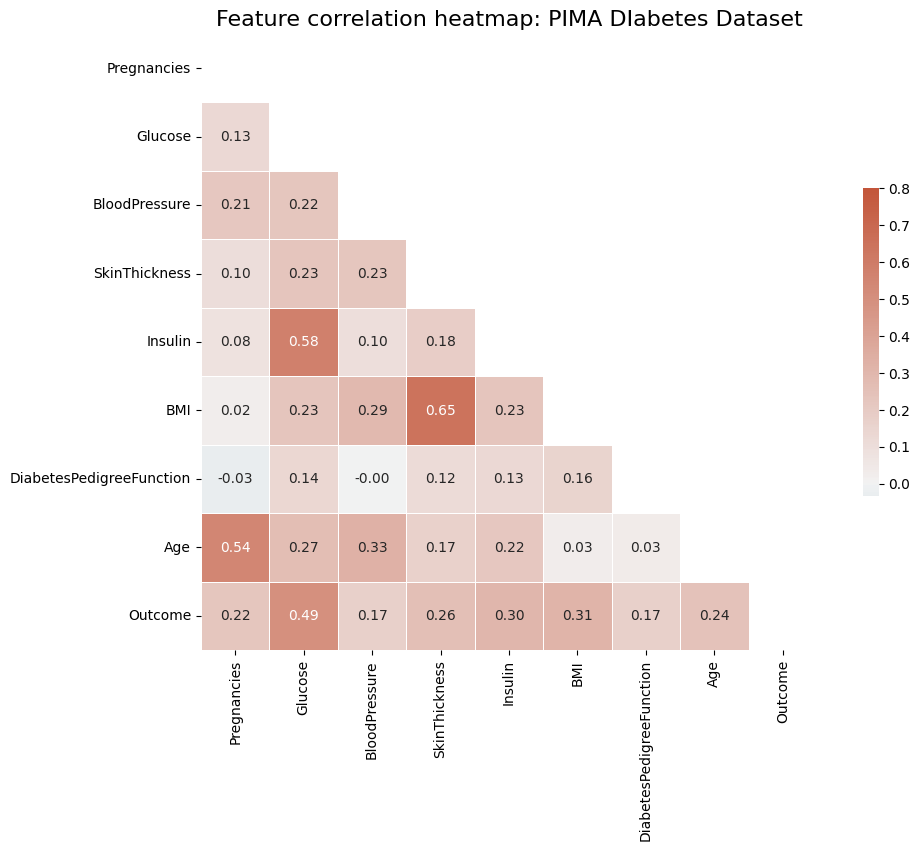

In [17]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=0.8, center=0, annot=True, fmt=".2f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

plt.title("Feature correlation heatmap: PIMA DIabetes Dataset", fontsize=16)
plt.show()

We can see that the features, with the most linear relationship with the outcome are Glucose, BMI, Age, Pregnancies, and DiabetesPedigreeFunction.

In [18]:
fig = px.scatter_3d(
    df.dropna(),
    x="Glucose",
    y="BMI",
    z="Age",
    color="Outcome",
    title="3D Feature visualization: Glucose vs BMI vs Age",
    labels={"Outcome": "Diabetes (1=Yes, 0=No)"},
    opacity=0.7,
    color_continuous_scale="Viridis"
)

fig.show()

In [19]:
X_dt = df.drop(["SkinThickness", "Insulin", "Outcome"], axis=1)
X_lr = X_dt.copy()
X_lr['BMI_Age_Interaction'] = X_lr['BMI'] * X_lr['Age']
y = df["Outcome"]
X_lr_train, X_lr_test, y_train, y_test = train_test_split(X_lr, y, test_size=0.2, random_state=42)
X_dt_train, X_dt_test, y_train, y_test = train_test_split(X_dt, y, test_size=0.2, random_state=42)

In [20]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("normalizer", PowerTransformer())
    ]
)

columns_to_use_lr = X_lr.columns.to_list()
columns_to_use_dt = X_dt.columns.to_list()
preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, columns_to_use_lr)
    ]
)
preprocessor_dt = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, columns_to_use_dt)
    ]
)

lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_lr),
        ("classifier", LogisticRegression())
    ]
)

dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_dt),
        ("classifier", DecisionTreeClassifier(random_state=42))
    ]
)

In [21]:
param_grid = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_dt_train, y_train)

best_dt_model = grid_search.best_estimator_
print(f"Best DT Params: {grid_search.best_params_}")


Best DT Params: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 4}


In [22]:
lr_pipeline.fit(X_lr_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('normalizer',
                                                                   PowerTransformer())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure', 'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age',
                                                   'BMI_Age_Interaction'])])),
                ('classifier', LogisticRegression())])

In [23]:
def evaluate_model(model, X_test, y_test, name):
  preds = model.predict(X_test)
  probs = model.predict_proba(X_test)[:, 1]

  print(f"--- {name} Performance ---")
  print(classification_report(y_test, preds))
  print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
  print(f"Precision: {precision_score(y_test, preds):.2f}")
  print(f"ROC-AUC:   {roc_auc_score(y_test, probs):.2f}")
  print("\n")

evaluate_model(lr_pipeline, X_lr_test, y_test, "Logistic Regression")
evaluate_model(best_dt_model, X_dt_test, y_test, "Decision Tree")


--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154

Accuracy: 0.77
Precision: 0.68
ROC-AUC:   0.82


--- Decision Tree Performance ---
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

Accuracy: 0.76
Precision: 0.68
ROC-AUC:   0.80




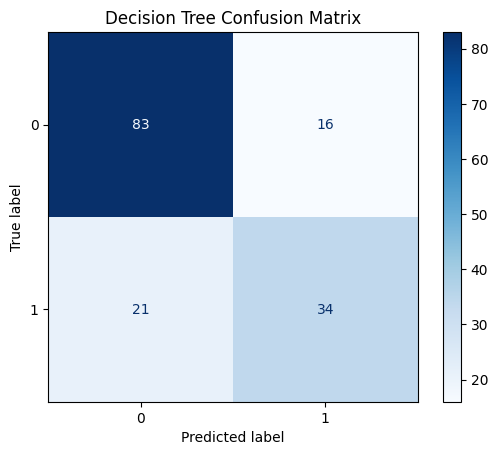

In [24]:
ConfusionMatrixDisplay.from_estimator(best_dt_model, X_dt_test, y_test, cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [25]:
joblib.dump(lr_pipeline, 'logistic_model.joblib')
joblib.dump(best_dt_model, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

In [26]:
training_data = df.drop(["SkinThickness", "Insulin"], axis=1)
training_data.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,33.6,0.627,50,1
1,1,85.0,66.0,26.6,0.351,31,0
2,8,183.0,64.0,23.3,0.672,32,1
3,1,89.0,66.0,28.1,0.167,21,0
4,0,137.0,40.0,43.1,2.288,33,1


In [27]:
training_data.to_csv("train_data.csv", index=False)